## Set up import Libraries , Load Data

In [145]:
# Data handing and static analysis
import pandas as pd 
import numpy as np 
from pandas_datareader import data
from scipy import stats

# Data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Optimization and allocation
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import black_litterman, BlackLittermanModel

# Financial data 
import quantstats as qs
import ta
import yfinance as yf

# Enabling Plotly offline
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Datetime and hiding warnings 
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

start_date = '2014-01-01'
end_date = '2024-12-31'

aapl = qs.utils.download_returns('AAPL')
aapl = aapl.loc[start_date:end_date]

msft = qs.utils.download_returns('MSFT')
msft = msft.loc[start_date:end_date]

nvda = qs.utils.download_returns('NVDA')
nvda = nvda.loc[start_date:end_date]

amzn= qs.utils.download_returns('AMZN')
amzn = amzn.loc[start_date:end_date]

goog = qs.utils.download_returns('GOOG')
goog = goog.loc[start_date:end_date]

meta = qs.utils.download_returns('META')
meta = meta.loc[start_date:end_date]

tsla = qs.utils.download_returns('TSLA')
tsla = tsla.loc[start_date:end_date]

sp500 = qs.utils.download_returns('^GSPC') # ^GSPC คือชื่อดัชนี S&P 500 บน Yahoo Finance
sp500 = sp500.loc[start_date:end_date]

list_stocks = [aapl, msft, nvda, amzn, goog, meta, tsla, sp500]

for df in list_stocks:
    if df.index.tz is not None:
        df.index = df.index.tz_convert(None)

for symbol in list_stocks:
    name = 'S&P500' if symbol.columns[0] == '^GSPC' else symbol.columns[0]
    print(f'Number of rows {name} : {len(symbol)}')

print('\n✅ Set up complete!')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Number of rows AAPL : 2768
Number of rows MSFT : 2768
Number of rows NVDA : 2768
Number of rows AMZN : 2768
Number of rows GOOG : 2768
Number of rows META : 2768
Number of rows TSLA : 2768
Number of rows S&P500 : 2768

✅ Set up complete!


## What is a Portfolio?

- พอร์ตโฟลิโอในตลาดการเงิน คือ กลุ่มสินทรัพย์ทางการเงิน เช่น หุ้น พันธบัตร สินค้าโภคภัณฑ์ และการลงทุนอื่นๆ ที่ถือครองโดยบุคคลหรือสถาบัน พอร์ตโฟลิโอช่วยให้ผู้ลงทุนสามารถกระจายการลงทุน จัดการความเสี่ยง และเพิ่มผลตอบแทนได้
- การสร้างพอร์ตการลงทุน นักลงทุนจะต้องเลือกสินทรัพย์ที่คาดว่าจะให้ผลตอบแทนที่ดีภายใต้สภาวะเศรษฐกิจและตลาดที่แตกต่างกัน ซึ่งเกี่ยวข้องกับการวิเคราะห์สถานการณ์ทางการเงิน วัตถุประสงค์ ระยะเวลา และการยอมรับความเสี่ยง ตลอดจนการวิจัย วิเคราะห์หลักทรัพย์ในแนวโน้มของตลาด
- น้ำหนักในพอร์ตโฟลิโอ (weights) คือ เปอร์เซ็นต์ของมูลค่ารวมที่จัดสรรให้กับสินทรัพย์แต่ละรายการ จะสะท้อนความสามารถของสินทรัพย์ในการสร้างผลตอบแทน และความเต็มใจที่จะยอมรับความเสี่ยง ผู้จัดการอาจใช้เทคนิคต่างๆ เช่น modern portfolio theory และ factor-based investing เพื่อกำหนดน้ำหนักที่เหมาะสมที่สุด 

In [147]:
# Example data aapl daily returns
aapl

Ticker,AAPL
Date,
2014-01-02,-0.014064
2014-01-03,-0.021965
2014-01-06,0.005453
2014-01-07,-0.007152
2014-01-08,0.006333
...,...
2024-12-24,0.011478
2024-12-26,0.003176
2024-12-27,-0.013242


In [150]:
# Merging daily returns for each stocks
returns_df = pd.concat([aapl, msft, nvda, amzn, goog, meta, tsla], axis=1) 

weights = np.array([0.1, 0.15, 0.25, 0.2, 0.15, 0.1, 0.05]) # Defining weights for each stocks
portfolio = returns_df.dot(weights) # Creating portfolio multiplying each stock for its respective weight 
portfolio # portfolio's daily returns

Date
2014-01-02   -0.006333
2014-01-03   -0.008518
2014-01-06    0.004963
2014-01-07    0.011729
2014-01-08    0.004808
                ...   
2024-12-24    0.013289
2024-12-26   -0.004325
2024-12-27   -0.017433
2024-12-30   -0.008749
2024-12-31   -0.013772
Length: 2768, dtype: float64

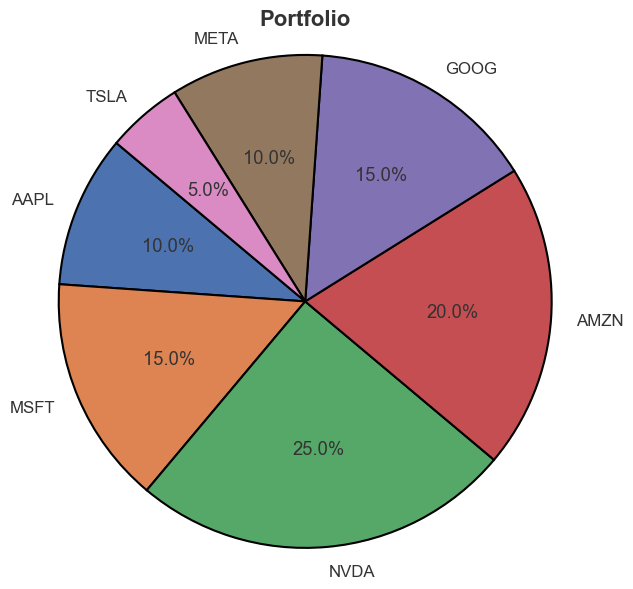

In [152]:
weights_pie_portfolio = pd.Series(weights)
labels=['AAPL','MSFT','NVDA','AMZN','GOOG','META','TSLA']
plt.figure(figsize=(6, 6))
plt.pie(weights_pie_portfolio, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=140, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5, 'linestyle': 'solid'})
plt.title('Portfolio', fontsize=16, fontweight='bold')
# plt.legend(labels, title="Assets", loc='best')
plt.tight_layout()
plt.axis('equal')
plt.show()

ใช้ Quantstats สร้างรายงานเพื่อเปรียบเทียบประสิทธิภาพของพอร์ตโฟลิโอและระดับความเสี่ยงกับเกณฑ์ ซึ่งในกรณีนี้คือ S&P500 เพื่อแสดงการวิเคราะห์ประสิทธิภาพและความเสี่ยงของพอร์ตโฟลิโอ

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2014-01-02   2014-01-02
End Period                 2024-12-31   2024-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          218.21%      3,662.98%
CAGR﹪                     7.53%        25.56%

Sharpe                     0.7          1.32
Prob. Sharpe Ratio         98.84%       100.0%
Smart Sharpe               0.64         1.22
Sortino                    0.97         1.92
Smart Sortino              0.9          1.77
Sortino/√2                 0.69         1.36
Smart Sortino/√2           0.63         1.25
Omega                      1.26         1.26

Max Drawdown               -33.92%      -48.64%
Longest DD Days            745          570
Volatility (ann.)          17.33%       28.05%
R^2                        0.68         0.68
Information Ratio          0.09         0.09
Calmar          

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-22,2022-11-03,2023-06-14,570,-48.641559,-47.856994
2,2018-10-02,2018-12-24,2019-10-25,389,-33.396376,-29.035453
3,2020-02-20,2020-03-16,2020-05-07,78,-30.847333,-29.117814
4,2015-12-30,2016-02-09,2016-04-05,98,-19.957647,-19.849438
5,2024-07-11,2024-08-05,2024-11-05,118,-18.205132,-18.101062


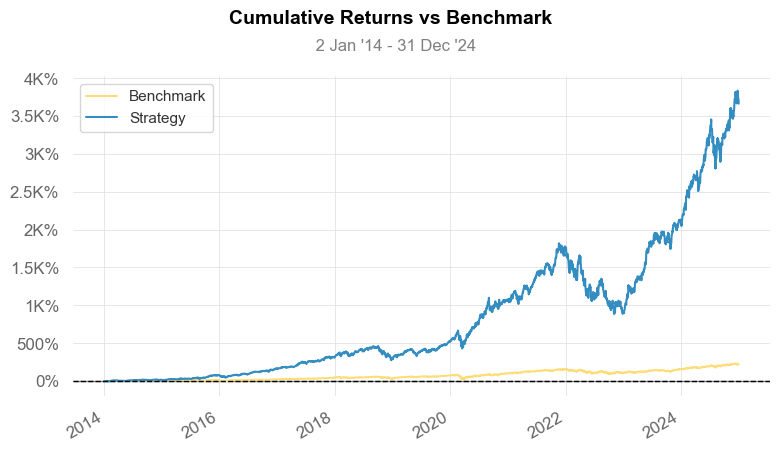

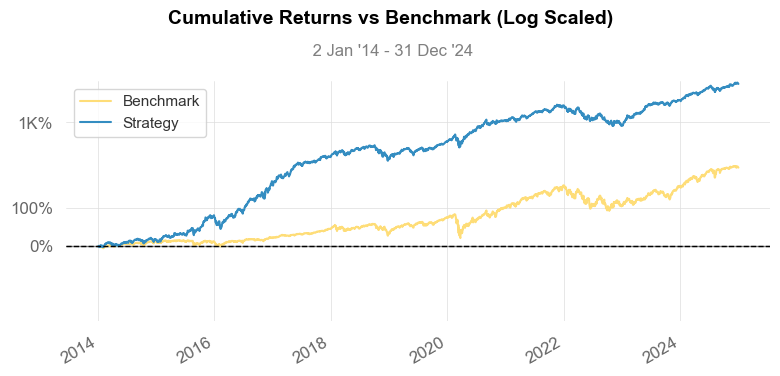

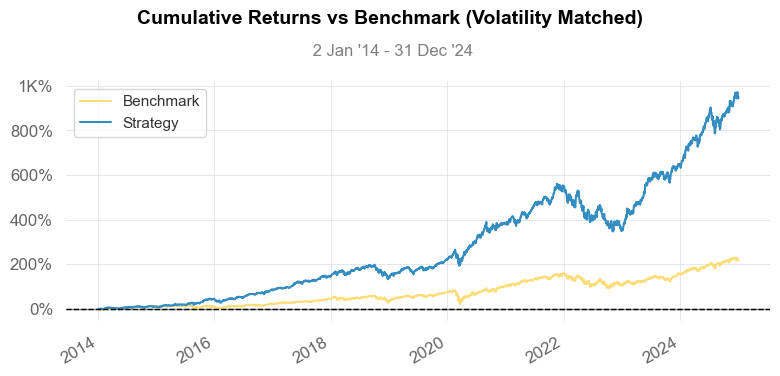

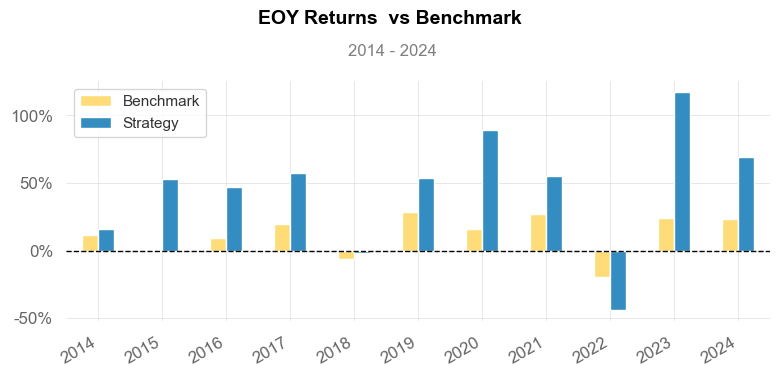

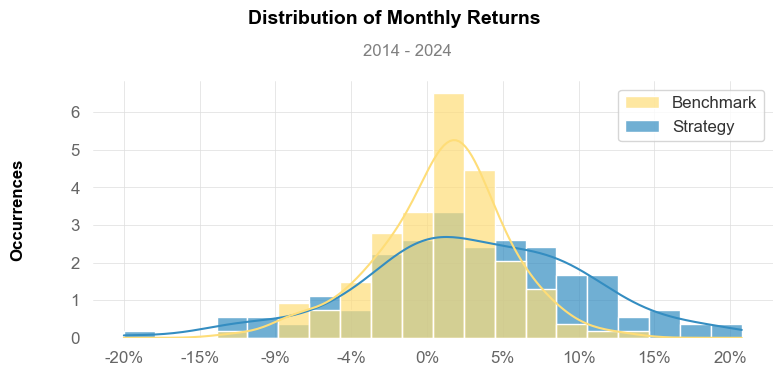

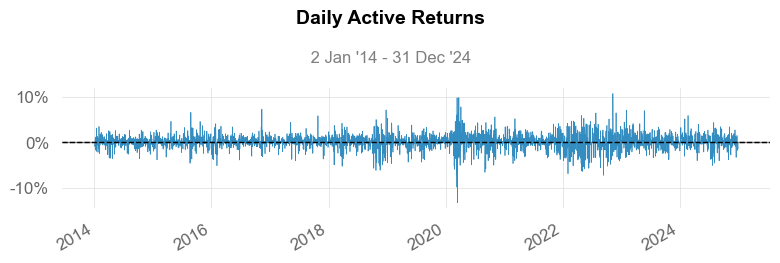

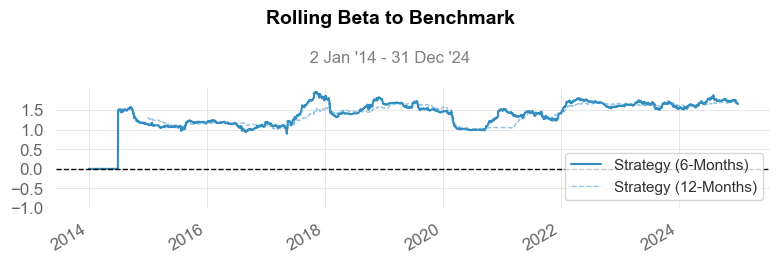

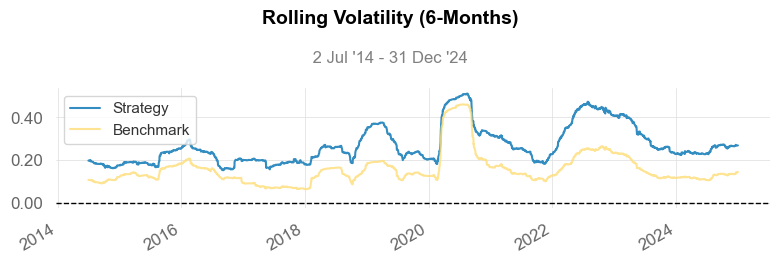

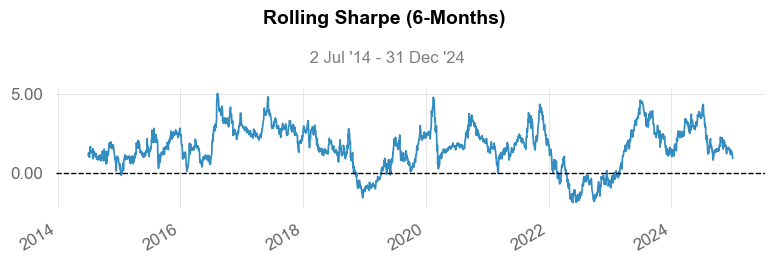

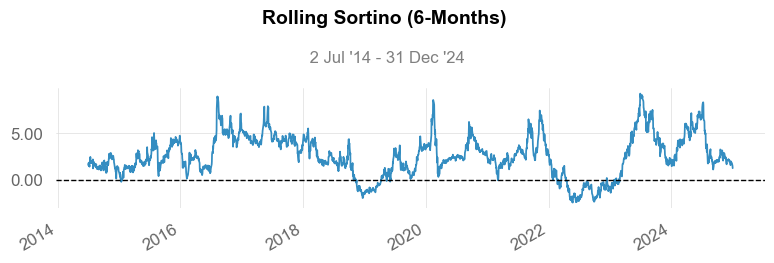

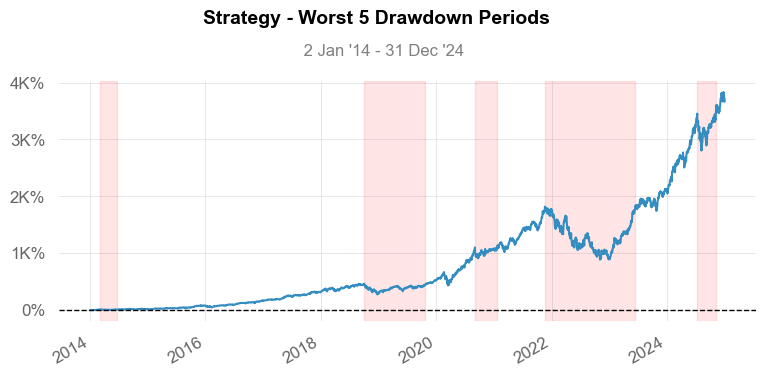

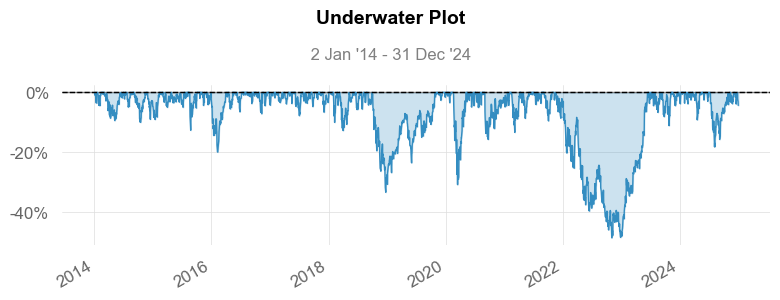

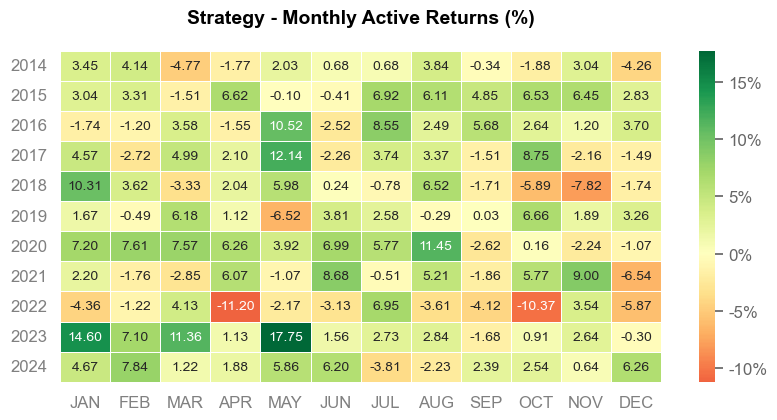

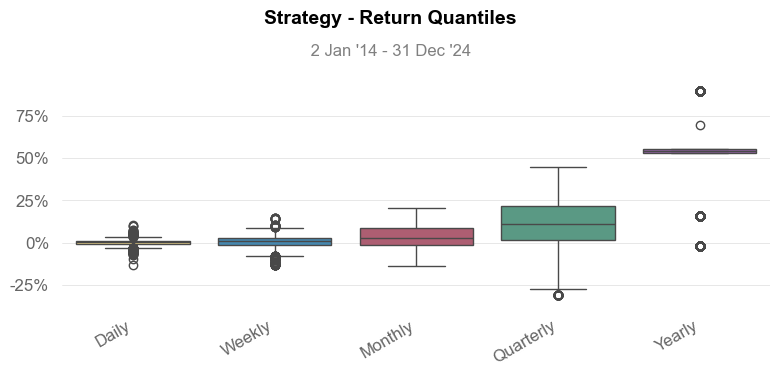

In [155]:
# Report on portfolio performance from January 2014 to December 2024
qs.reports.full(portfolio, benchmark=sp500)

การเปรียบเทียบระหว่าง Benchmark (S&P500) กับ Strategy (Portfolio's)
- พอร์ตโฟลิโอเรามี ผลตอบแทนรวม (Cumulative Return) ถึง 3,662% เทียบกับ S&P500 เพียง 218%
- มี CAGR หรือผลตอบแทนทบต้นรายปีของพอร์ตโฟลิโอที่ 25.56% ซึ่งถือว่าสูงมากเมื่อเทียบกับ S&P500 ที่ 7.53% ของตลาดโดยรวม
- นอกจากนี้ยังมี Sharpe Ratio 1.32 ซึ่งบ่งชี้ถึงความสามารถในการสร้างผลตอบแทนต่อหน่วยความเสี่ยงที่ดีกว่า S&P500 (0.7) 
- พอร์ตโฟลิโอเรายังเผชิญ Max Drawdown ที่สูงกว่า (-48.64%) แสดงถึงช่วงเวลาที่ขาดทุนมากที่สุด แม้จะมีความผันผวนสูงกว่า (Volatility 28.05%) 
- Calmar Ratio 0.53 ใช้วัดประสิทธิภาพของผลตอบแทนเทียบกับความเสี่ยงจาก Drawdown ซึ่งสามารถสร้างผลตอบแทน เฉลี่ย 0.53 หน่วย ต่อการขาดทุน 1 หน่วยใน Drawdown สูงสุด
- Alpha ของพอร์ตโฟลิโอเรา 0.21 แสดงว่าสร้างผลตอบแทนที่สูงกว่าค่าที่คาดไว้ตามความเสี่ยงที่รับไว้ (Beta = 1.34)
- Correlation 82.64% บอกความสัมพันธ์ระหว่างพอร์ตโฟลิโอกับตลาด แปลว่า พอร์ตโฟลิโอเรามีแนวโน้มไปในทิศทางเดียวกับตลาดค่อนข้างมาก
- Recovery Factor (8.35) ความสามารถในการฟื้นตัวจากการขาดทุน (Drawdown) ที่ดีกว่า S&P500
- พอร์ตโฟลิโอเรา มี Ulcer Index = 0.13 สูงกว่า Benchmark เล็กน้อย แปลว่าพอร์ตมีการลดลงจากจุดสูงสุดที่รุนแรงหรือยาวนานกว่า
- Serenity Index : Benchmark = 1.39 | Strategy = 2.18 วัดสมดุลระหว่างผลตอบแทนและความเสี่ยง แสดงว่าพอร์ตโฟลิโอนี้ทั้งให้ผลตอบแทนดีและนิ่ง 

---

## Optimizing Portfolio
- Optimizing Portfolio หรือ การเพิ่มประสิทธิภาพพอร์ตการลงทุน โดยการหาวิธีจัดสรรน้ำหนัก (weights) ของสินทรัพย์ในพอร์ตการลงทุนอย่างเหมาะสม เพื่อให้ได้ผลตอบแทนสูงสุดในขณะที่มีความเสี่ยงต่ำสุด หรือ เพิ่มผลตอบแทนที่เหมาะสมกับระดับความเสี่ยงที่ยอมรับได้ โดยใช้วิธีการต่างๆ เช่น Mean-Variance Optimization, Efficient Frontier, และ Sharpe Ratio เพื่อช่วยในการตัดสินใจ

ปัจจัยหลักในการเพิ่มประสิทธิภาพพอร์ต:
- ผลตอบแทนที่คาดหวัง (Expected Returns) ผลตอบแทนที่คาดว่าจะได้รับจากสินทรัพย์ในพอร์ต โดยคำนวณจากประวัติราคา
- ความเสี่ยง (Risk) มักวัดจาก ความผันผวน (Volatility) หรือ ค่าเบี่ยงเบนมาตรฐาน (Standard Deviation) ของผลตอบแทน พอร์ตที่มีความเสี่ยงต่ำมักจะมาจากการกระจายการลงทุนในสินทรัพย์หลายๆ ตัว
- การกระจายความเสี่ยง (Diversification) การลงทุนในสินทรัพย์ที่มีความสัมพันธ์กันน้อยหรือไม่สัมพันธ์เลย ช่วยลดความเสี่ยงโดยรวม

วิธีการที่ใช้ในการเพิ่มประสิทธิภาพพอร์ต:
- Markowitz Efficient Frontier เป็นโมเดลที่พัฒนาโดย Harry Markowitz ซึ่งจะช่วยหาความสัมพันธ์ระหว่างผลตอบแทนและความเสี่ยง
- Efficient Frontier เส้นที่แสดงชุดของพอร์ตที่ให้ผลตอบแทนสูงสุดสำหรับแต่ละระดับของความเสี่ยง การเลือกพอร์ตที่อยู่บน Efficient Frontier จะทำให้เราได้ผลตอบแทนที่ดีที่สุดสำหรับระดับความเสี่ยงที่ยอมรับได้
- Sharpe Ratio ใช้สำหรับประเมินพอร์ตโดยคำนวณผลตอบแทนที่เกินกว่าความเสี่ยง การมีค่า Sharpe Ratio ที่สูงหมายถึงพอร์ตที่มีผลตอบแทนมากกว่าความเสี่ยง
- Black-Litterman Model เป็นโมเดลที่ใช้การผสมความเชื่อของนักลงทุน (เช่น การคาดการณ์ตลาด) กับข้อมูลทางสถิติ เพื่อให้ได้พอร์ตการลงทุนที่มีความเสี่ยงต่ำที่สุดในขณะที่ยังได้ผลตอบแทนที่ดี

In [159]:
# Getting dataframes info for Stocks using yfinance
start_date = '2014-01-01'
end_date = '2024-12-31'

aapl_df = yf.download('AAPL', start=start_date, end=end_date)
msft_df = yf.download('MSFT', start=start_date, end=end_date)  
nvda_df = yf.download('NVDA', start=start_date, end=end_date)   
amzn_df = yf.download('AMZN', start=start_date, end=end_date)
goog_df = yf.download('GOOG', start=start_date, end=end_date)
meta_df = yf.download('META', start=start_date, end=end_date)
tsla_df = yf.download('TSLA', start=start_date, end=end_date) 

print('\n✅ Getting info for stocks complete!')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Getting info for stocks complete!


In [160]:
# Example data meta 
# Close : The closing price of the stock 
# Open : The price at which the stock opened at the beginning 
# High : The highest stock price recorded 
# Low : The lowest stock price recorded 
# Volume : The total trading volume
meta_df

Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2014-01-02,54.453358,54.960967,53.935797,54.572798,43195500
2014-01-03,54.304066,55.388953,54.274204,54.761907,38246200
2014-01-06,56.931679,56.991395,53.796454,54.164717,68852600
2014-01-07,57.648308,58.275354,56.951594,57.429342,77207400
2014-01-08,57.956844,58.136000,56.961535,57.329799,56682400
...,...,...,...,...,...
2024-12-23,599.316772,600.555721,585.728886,589.075884,10205800
2024-12-24,607.209778,607.449555,598.747336,602.184220,4726100


In [161]:
stocks_df = [aapl_df, msft_df, nvda_df, amzn_df, goog_df, meta_df, tsla_df]

# Extracting 'Close' for each stocks
for df in range(len(stocks_df)): 
    stocks_df[df] = stocks_df[df]['Close']
    
# Merging and creating an 'Close' dataframe for stocks
df = pd.concat(stocks_df, axis=1, join='outer')
df

Ticker,AAPL,MSFT,NVDA,AMZN,GOOG,META,TSLA
Date,,,,,,,
2014-01-02,17.215361,30.996408,0.373932,19.898500,27.593388,54.453358,10.006667
2014-01-03,16.837214,30.787886,0.369452,19.822001,27.392099,54.304066,9.970667
2014-01-06,16.929035,30.137266,0.374403,19.681499,27.697506,56.931679,9.800000
2014-01-07,16.807966,30.370815,0.380533,19.901501,28.231462,57.648308,9.957333
2014-01-08,16.914404,29.828627,0.385720,20.096001,28.290213,57.956844,10.085333
...,...,...,...,...,...,...,...
2024-12-23,254.989655,434.379028,139.657150,225.059998,195.766968,599.316772,430.600006
2024-12-24,257.916443,438.450836,140.207108,229.050003,197.345184,607.209778,462.279999
2024-12-26,258.735504,437.233276,139.917130,227.050003,196.875717,602.813660,454.130005


The dataframe above will be used as input for the algorithms to optimize the portfolio

### Markowitz Mean-Variance Optimization Model (Optimizing Portfolio)
Markowitz Mean-Variance Optimization Model เป็นโมเดลที่พัฒนาโดย Harry Markowitz เป็นการบริหารพอร์ตการลงทุน โดยมุ่งเน้นการหาสมดุลระหว่าง ผลตอบแทน (Return) และ ความเสี่ยง (Risk) ของพอร์ต โดยการใช้ Efficient Frontier และ Sharpe Ratio เพื่อเลือกพอร์ตการลงทุนที่มีประสิทธิภาพสูงสุดตามระดับความเสี่ยงที่ยอมรับได้ของนักลงทุน
- ผลตอบแทนที่คาดหวัง (Expected Return) เป็นค่าผลตอบแทนเฉลี่ยที่คาดว่าจะได้รับจากสินทรัพย์ในพอร์ตการลงทุน
- ความเสี่ยง (Risk) มักวัดจากค่าเบี่ยงเบนมาตรฐาน (Standard Deviation) หรือ ความแปรปรวน (Variance) ของผลตอบแทน
- ความสัมพันธ์ระหว่างสินทรัพย์ (Correlation) เป็นการวัดความสัมพันธ์ระหว่างผลตอบแทนของสินทรัพย์ต่างๆ ช่วยให้ทราบถึงความสัมพันธ์ไม่ว่าจะเป็นการเพิ่มขึ้นหรือการลดลงในทิศทางเดียวกัน
- Efficient Frontier คือเส้นที่แสดงชุดของพอร์ตการลงทุนที่ให้ผลตอบแทนสูงสุด สำหรับแต่ละระดับของความเสี่ยง พอร์ตที่อยู่บนเส้นนี้ถือเป็นพอร์ตที่มีประสิทธิภาพสูงสุด 

In [164]:
# Importing libraries for portfolio optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [165]:
# Calculating the annualized expected returns and the annualized sample covariance matrix
mu = expected_returns.mean_historical_return(df) # expected(avg) return รายปีของหุ้นแต่ละตัวในพอร์ต
S = risk_models.sample_cov(df) # covariance matrix แบบ annualized วัด ความเสี่ยงร่วมระหว่างหุ้นในพอร์ต

In [167]:
mu # Visualizing the annualized expected returns

Ticker
AAPL    0.276941
MSFT    0.269112
NVDA    0.712883
AMZN    0.245409
GOOG    0.193586
META    0.242588
TSLA    0.404808
dtype: float64

<Axes: xlabel='Ticker', ylabel='Ticker'>

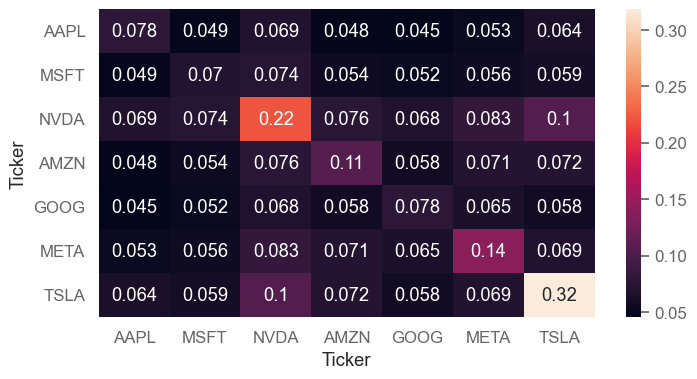

In [168]:
# Visualizing the covariance matrix
plt.figure(figsize=(8,4))
sns.heatmap(data=S, annot=True)

In [176]:
ef = EfficientFrontier(mu, S) # Providing expected returns and covariance matrix as input
weights = ef.max_sharpe() # Optimizing weights for Sharpe ratio maximization  

clean_weights_max_sharp = ef.clean_weights()
clean_weights_max_sharp 

OrderedDict([('AAPL', 0.20441),
             ('MSFT', 0.04002),
             ('NVDA', 0.72099),
             ('AMZN', 0.0),
             ('GOOG', 0.0),
             ('META', 0.0),
             ('TSLA', 0.03458)])

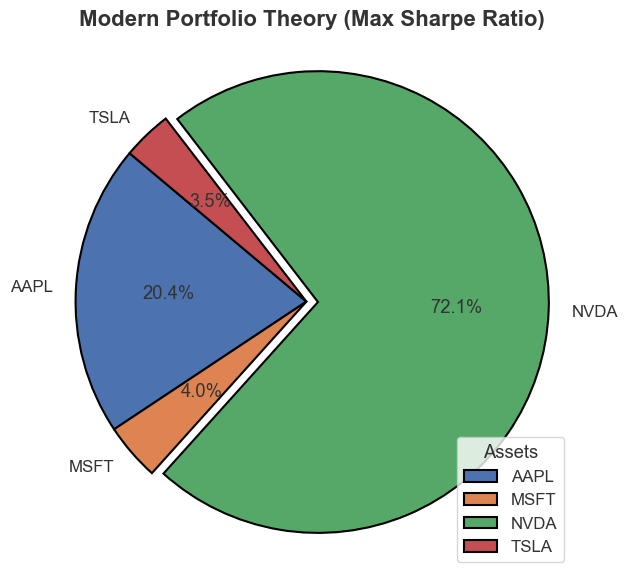

In [178]:
weights_pie_MPT  = pd.Series(clean_weights_max_sharp)
weights_pie_MPT = weights_pie_MPT[weights_pie_MPT > 0]

explode = [0, 0, 0.05, 0]
plt.figure(figsize=(6, 6))
plt.pie(weights_pie_MPT, 
        labels=weights_pie_MPT.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5, 'linestyle': 'solid'}, 
        explode=explode)
plt.title('Modern Portfolio Theory (Max Sharpe Ratio)', fontsize=16, fontweight='bold')
plt.legend(weights_pie_MPT.index, title="Assets", loc='best')
plt.tight_layout()
plt.axis('equal')
plt.show()

In [180]:
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility() # Optimizing weights for volatility min

clean_weights_min_volati = ef.clean_weights() 
clean_weights_min_volati

OrderedDict([('AAPL', 0.322),
             ('MSFT', 0.33639),
             ('NVDA', 0.0),
             ('AMZN', 0.07352),
             ('GOOG', 0.26809),
             ('META', 0.0),
             ('TSLA', 0.0)])

In [182]:
# Creating new portfolio with optimized weights with Sharpe ratio maximization
new_weights = np.array([clean_weights_max_sharp['AAPL'], clean_weights_max_sharp['MSFT'], clean_weights_max_sharp['NVDA'],
                       clean_weights_max_sharp['AMZN'], clean_weights_max_sharp['GOOG'], clean_weights_max_sharp['META'],
                       clean_weights_max_sharp['TSLA']])

optimized_portfolio = returns_df.dot(new_weights)
optimized_portfolio # Optimizing Portfolio daily returns

Date
2014-01-02   -0.010419
2014-01-03   -0.013521
2014-01-06    0.009339
2014-01-07    0.011208
2014-01-08    0.010852
                ...   
2024-12-24    0.008105
2024-12-26   -0.001563
2024-12-27   -0.020156
2024-12-30   -0.001857
2024-12-31   -0.019661
Length: 2768, dtype: float64

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2014-01-02   2014-01-02
End Period                 2024-12-31   2024-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          3,662.98%    18,350.00%
CAGR﹪                     25.56%       38.74%

Sharpe                     1.32         1.42
Prob. Sharpe Ratio         100.0%       100.0%
Smart Sharpe               1.22         1.32
Sortino                    1.92         2.18
Smart Sortino              1.78         2.02
Sortino/√2                 1.36         1.54
Smart Sortino/√2           1.26         1.43
Omega                      1.29         1.29

Max Drawdown               -48.64%      -56.48%
Longest DD Days            570          541
Volatility (ann.)          28.05%       38.73%
R^2                        0.81         0.81
Information Ratio          0.06         0.06
Calmar         

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-30,2022-10-14,2023-05-24,541,-56.482245,-54.202135
2,2018-10-02,2018-12-24,2020-01-08,464,-49.270039,-46.979220
3,2020-02-20,2020-03-16,2020-05-08,79,-35.238099,-33.795398
4,2015-12-07,2016-02-08,2016-03-24,109,-23.900436,-23.875923
5,2024-07-11,2024-08-07,2024-10-11,93,-22.787725,-21.935003


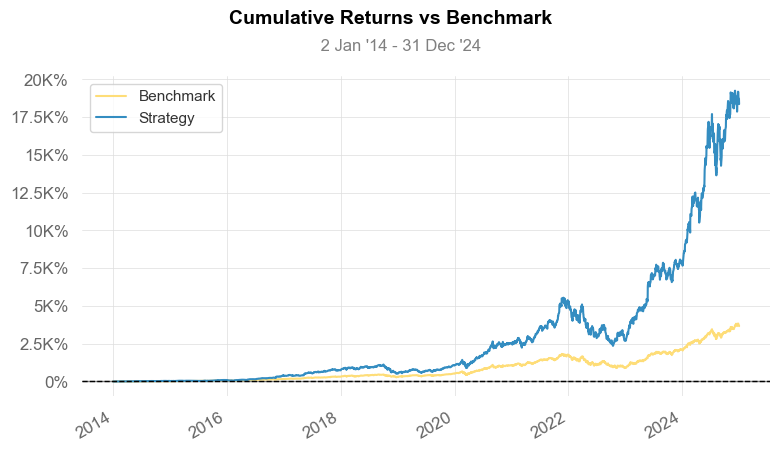

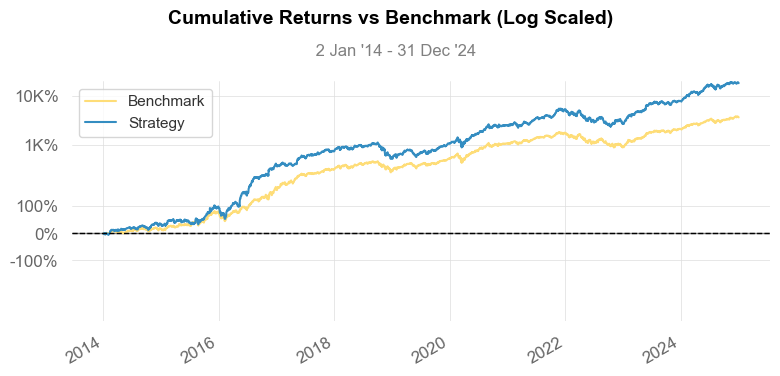

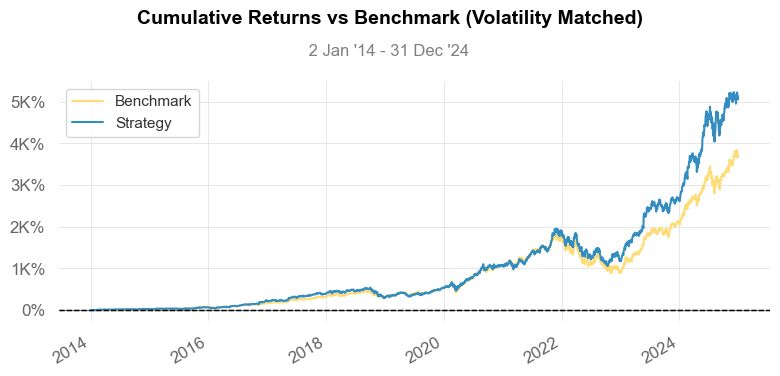

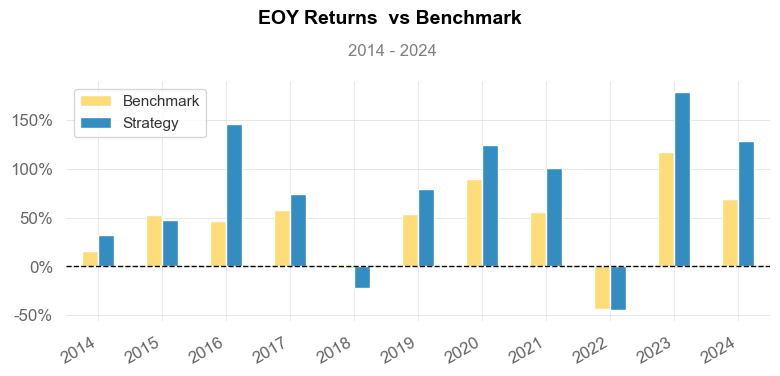

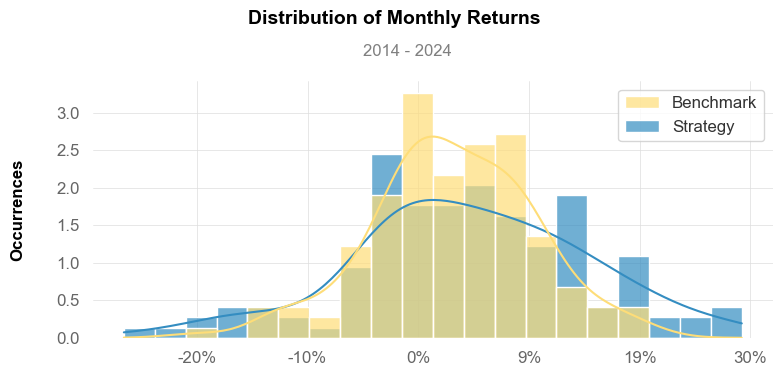

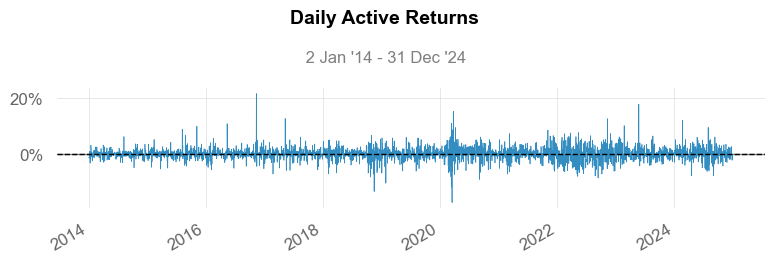

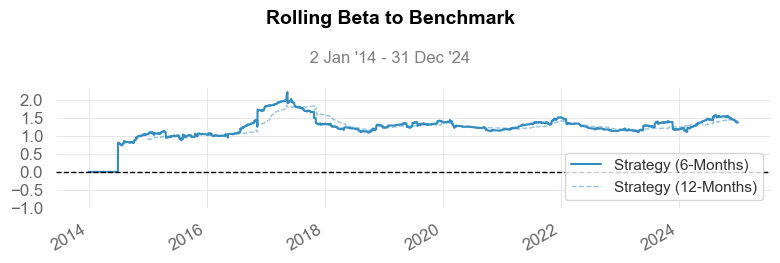

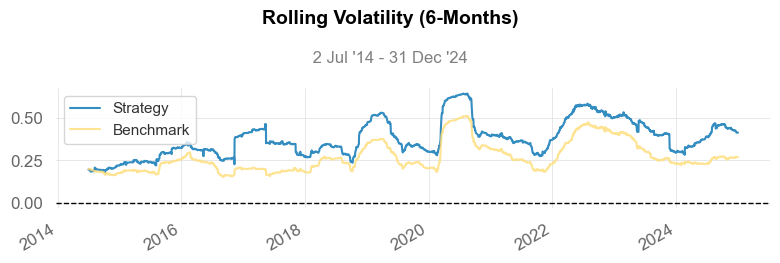

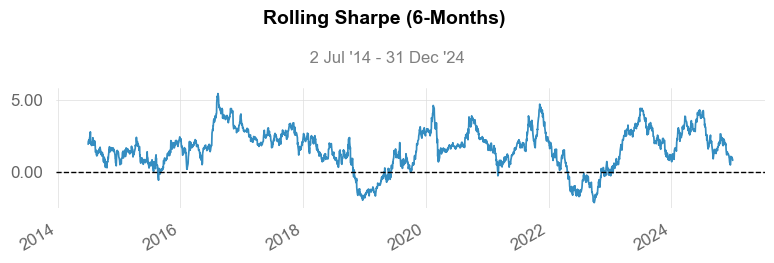

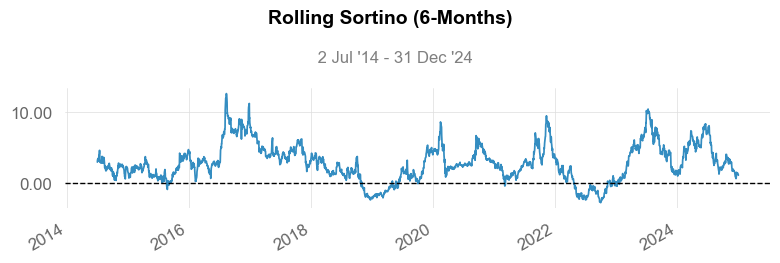

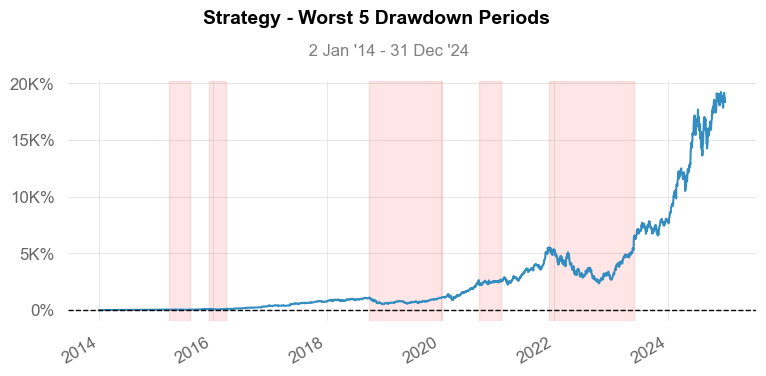

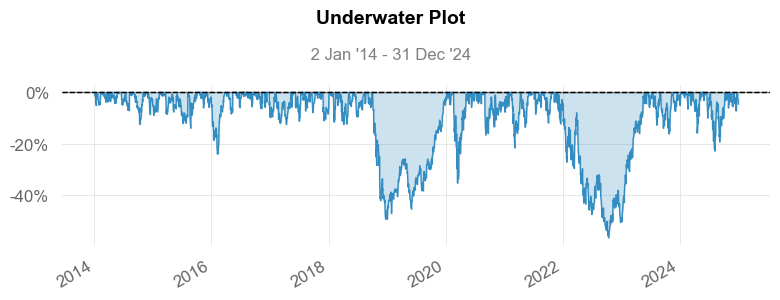

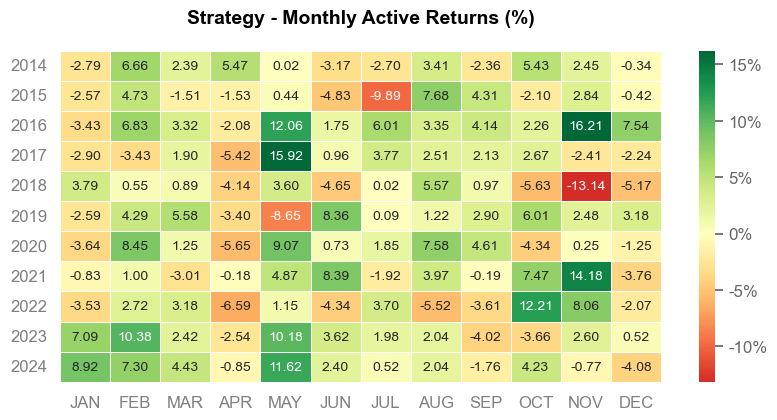

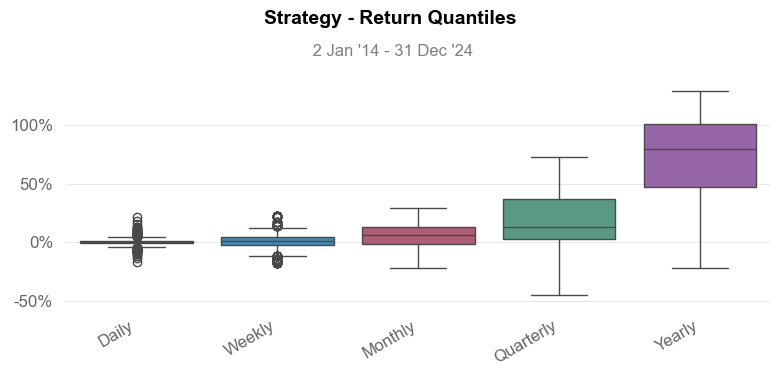

In [184]:
# Displaying new reports comparing the optimized portfolio to the first portfolio constructed
qs.reports.full(optimized_portfolio, benchmark=portfolio)

### Black-Litterman Allocation Model (Optimizing Portfolio)

- Black-Litterman Allocation Model (BL Model) เป็นโมเดลที่ใช้ในการกำหนดน้ำหนักของสินทรัพย์ในพอร์ตการลงทุน เพื่อปรับสมดุลของความเสี่ยงและผลตอบแทน โดยการใช้ข้อมูลจากการคาดการณ์ของนักลงทุน (views) และการคำนวณของตลาด (market equilibrium) ทำให้น้ำหนักของสินทรัพย์มีความยืดหยุ่นมากขึ้นและสมเหตุสมผลกับความคิดเห็นหรือการคาดการณ์ของนักลงทุน
- BL Model พัฒนาขึ้นโดย Fischer Black และ Robert Litterman ในปี 1990s เพื่อปรับปรุง Markowitz Mean-Variance Optimization Model ที่มีข้อจำกัดการคาดการณ์ผลตอบแทนในตลาด การคาดการณ์สามารถผิดพลาดได้หากไม่สะท้อนข้อมูลที่ถูกต้องในตลาด ซึ่ง BL Model แก้ไขข้อจำกัดโดยให้ความสำคัญกับข้อมูลตลาด (Market Equilibrium) และความคิดเห็นของนักลงทุน (Investor Views)

- ค่า delta ตามโมเดล Black-Litterman ใช้สำหรับการหาค่าความเสี่ยงที่นักลงทุนยินดีรับ (Risk Aversion) โดยขึ้นอยู่กับราคาตลาด (market prices) ซึ่งช่วยคำนวณพอร์ตโฟลิโอจากการมุมมองต่างๆ และราคาตลาด โดย black_litterman จะคำนวณค่า delta พิจารณาจากข้อมูลราคาตลาดที่มีอยู่ใน market prices 

หลักการทำงานของ Black-Litterman Model
- Market Equilibrium ใช้ผลตอบแทนที่คาดการณ์จาก Capital Market Line (CML) ซึ่งสะท้อนผลตอบแทนของตลาดที่อยู่ในสถานะสมดุล (Equilibrium) โดยสมมติฐานคือ หากไม่มีข้อมูลเพิ่มเติมจากตลาด (ไม่มี Views) นักลงทุนควรลงทุนในสินทรัพย์ตามสัดส่วนที่ตลาดกำหนด
- Investor Views นักลงทุนสามารถใส่ความคิดเห็นหรือการคาดการณ์ (Views) เกี่ยวกับสินทรัพย์ได้ เช่น คาดว่า หุ้น X จะให้ผลตอบแทนสูงกว่าหุ้น Y ในปีหน้า (การคาดการณ์นี้จะรวมกับข้อมูลตลาดในการคำนวณหาน้ำหนักของสินทรัพย์ในพอร์ต)
- Risk of the Views แต่ละการคาดการณ์หรือ View จะมีความเชื่อมั่นหรือความเสี่ยงที่ต่างกันออกไป (เช่น คาดการณ์ที่เชื่อมั่นสูงกับคาดการณ์ที่ไม่แน่ใจ) ซึ่งจะถูกนำมาพิจารณาในการคำนวณสมดุลของพอร์ตการลงทุน
- Combination of Market and Views โมเดลจะคำนวณน้ำหนักของสินทรัพย์โดยใช้ข้อมูลจากตลาดและจากการคาดการณ์ (Views) ของนักลงทุน เพื่อหาน้ำหนักที่เหมาะสมที่สุดในพอร์ตการลงทุนที่มีความเสี่ยงที่สมดุล

Views

ในโมเดล Black-Litterman นักลงทุนสามารถแสดงความคิดเห็นของตนเองได้ทั้งแบบสัมบูรณ์และแบบสัมพันธ์กัน มุมมองสัมบูรณ์ เช่น "APPL จะให้ผลตอบแทน 10%" ในขณะที่มุมมองสัมพัทธ์เช่น "AMZN จะให้ผลตอบแทนเหนือกว่า AMD 10%" มุมมองเหล่านี้จะต้องระบุไว้ในเวกเตอร์ Q และแมปเข้าในสินทรัพย์แต่ละรายการผ่านเมทริกซ์ P

Confidences

กำหนดสัดส่วนการลงทุนในแต่ละสินทรัพย์ โดยอิงจากระดับความมั่นใจของนักลงทุนต่อมุมมอง(views) ของตน ซึ่งสามารถระบุได้เป็ 0 ถึง 1 โดย ค่า 0 หมายถึงมีความมั่นใจต่ำ ค่า 1 หมายถึงมีความมั่นใจสูง การใช้ Confidence Matrix ช่วยให้ปรับพอร์ตสอดคล้องกับความมั่นใจของตน

In [190]:
# Obtaining market cap for stocks
assets = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOG', 'META', 'TSLA']

market_caps = {}
for symbol in assets:
    stock = yf.Ticker(symbol)  
    market_caps[symbol] = stock.info['marketCap'] 

market_caps = pd.Series(market_caps)
market_caps

AAPL    2976629129216
MSFT    2887729545216
NVDA    2706691850240
AMZN    1961914400768
GOOG    1927958888448
META    1377221476352
TSLA     811333058560
dtype: int64

In [191]:
# Obtaining closing prices for the SP500
start_date = '2014-01-01'
end_date = '2024-12-31'

market_prices = yf.download('^GSPC', start=start_date, end=end_date)['Close']
market_prices

[*********************100%***********************]  1 of 1 completed


Ticker,^GSPC
Date,
2014-01-02,1831.979980
2014-01-03,1831.369995
2014-01-06,1826.770020
2014-01-07,1837.880005
2014-01-08,1837.489990
...,...
2024-12-23,5974.069824
2024-12-24,6040.040039
2024-12-26,6037.589844


เราต้องประเมินระดับความเสี่ยงในตลาดก่อน ซึ่งแสดงโดยพารามิเตอร์ที่เรียกว่า delta ซึ่งเราคำนวณโดยใช้ราคาปิดของ SP500 ยิ่งค่า delta สูงขึ้น ความเสี่ยงของตลาดก็จะยิ่งมากขึ้น

In [195]:
# Obtaining market-implied risk aversion, the delta
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

4.0509243896499525

ค่า delta ที่ได้จากการคำนวณนี้จะเป็นตัวชี้วัดว่า นักลงทุนในตลาดมีความเสี่ยงที่ยอมรับได้มากน้อยแค่ไหน
- ค่าที่สูง (เช่น 3 หรือ 4) หมายความว่า นักลงทุนในตลาดมีความเสี่ยงที่ยอมรับได้ต่ำ (risk-averse) โดยแสดงให้เห็นว่านักลงทุนไม่พร้อมที่จะรับความเสี่ยงสูงในการลงทุน
- ค่าที่ต่ำ (เช่น 0.5 หรือ 1) หมายความว่า นักลงทุนในตลาดยินดีรับความเสี่ยงสูง (risk-seeking) ซึ่งสามารถแสดงถึงการยอมรับผลตอบแทนที่มีความผันผวนมากขึ้น

ด้วยข้อมูลนี้ สามารถคำนวณผลตอบแทนที่คาดหวังไว้ล่วงหน้าของหุ้นแต่ละตัวโดยอิงจากมูลค่าตลาด delta และ covariance matrix S ซึ่งเราได้มาก่อนที่จะเพิ่มประสิทธิภาพพอร์ตโฟลิโอของเราด้วย Markowitz Mean-Variance Model 

In [198]:
# Changing columns and index to uppercase so it matches market_caps
S.index = S.index.str.upper()
S.columns = S.columns.str.upper()
S

Ticker,AAPL,MSFT,NVDA,AMZN,GOOG,META,TSLA
Ticker,,,,,,,
AAPL,0.077897,0.048820,0.068958,0.048345,0.045416,0.052738,0.064063
MSFT,0.048820,0.070240,0.073523,0.054182,0.051863,0.055764,0.058911
NVDA,0.068958,0.073523,0.220582,0.076291,0.068237,0.082635,0.104837
AMZN,0.048345,0.054182,0.076291,0.107211,0.058040,0.071029,0.071794
GOOG,0.045416,0.051863,0.068237,0.058040,0.077953,0.064975,0.058099
META,0.052738,0.055764,0.082635,0.071029,0.064975,0.139356,0.069387
TSLA,0.064063,0.058911,0.104837,0.071794,0.058099,0.069387,0.318195


In [200]:
# Obtaining Prior estimates 
prior = black_litterman.market_implied_prior_returns(market_caps, delta, S)
prior

Ticker
AAPL    0.239612
MSFT    0.242800
NVDA    0.413326
AMZN    0.272423
GOOG    0.240694
META    0.291600
TSLA    0.345976
dtype: float64

คำนวณ ผลตอบแทนที่คาดการณ์จากตลาด (Market-Implied Prior Returns) ซึ่งเป็นส่วนสำคัญของโมเดล Black-Litterman ก่อนที่จะนำมาผสมกับความเห็นของนักลงทุน (Views)

ทำไมต้องคำนวณ Market-Implied Prior Returns?
- Black-Litterman ไม่ได้เริ่มจากการใช้ historical returns ตรงๆ แบบใน Markowitz Model แต่ใช้แนวคิดว่า "ถ้าตลาดอยู่ใน "equilibrium" (ดุลยภาพ) แล้ว น้ำหนักของสินทรัพย์ที่ตลาดให้ (market cap) ก็ควรสะท้อนถึงผลตอบแทนที่คาดหวังโดยปริยาย"

In [203]:
# View 1 : TSLA will go down 15%
# View 2 : MSFT will raise by 7%
# View 3 : NVDA will raise by 15%
# View 4 : GOOG will outperform META by 6%
# View 5 : AAPL will go down 5%
# View 6 : AMZN will raise by 10%
# View 7 : NVDA will outperform TSLA by 20%
# View 8 : AAPL will underperform AMZN by 10%

# Q : Expect return to receive on an asset from an investor's perspective (View)
Q = np.array([
            -0.15,  # TSLA -15%↓
            0.07,   # MSFT +7%↑
            0.15,   # NVDA +15%↑
            0.06,   # GOOG > META
            -0.05,  # AAPL -5%↓
            0.1,   # AMZN +10%↑
            0.2,   # NVDA > TSLA
            -0.1   # AAPL < AMZN
]) 

# Linking views to assets
# P : Matrix that shows which assets are relevant to which perspectives and in what proportion (each row = 1 view)
P = np.array([
    [0, 0, 0, 0, 0, 0, 1],    # View 1 : TSLA
    [0, 1, 0, 0, 0, 0, 0],    # View 2 : MSFT
    [0, 0, 1, 0, 0, 0, 0],    # View 3 : NVDA
    [-0.5, 0, 0, 0, 1, -0.5, 0],   # View 4 : GOOG - META
    [1, 0, 0, 0, 0, 0, 0],    # View 5 : AAPL
    [0, 0, 0, 1, 0, 0, 0],    # View 6 : AMZN
    [0.2, 0.2, 0.6, 0, 0, 0, -1],   # View 7: NVDA - TSLA
    [-0.8, 0, -0.2, 1, 0, 0, 0],   # View 8 : AAPL - AMZN
])

# Providing confidence levels 
# Confidence : Our confidence in each perspective (Q)
# Closer to 0.0 = Low confidence
# Closer to 1.0 = High confidence
confidences = np.array([ 0.6, 0.7, 0.8, 0.4, 0.6, 0.7, 0.7, 0.65 ])

In [205]:
# Creating model
bl_model = BlackLittermanModel(S, # Covariance Matrix
                         pi=prior,  # Prior expected returns
                         Q=Q, # Vector of views
                         P=P, # Matrix mapping the views
                         omega='idzorek',  # Method to estimate uncertainty level of the views based on historical data
                         view_confidences=confidences) # Confidences

In [207]:
rets = bl_model.bl_returns()  # Calculating Expected returns
ef = EfficientFrontier(rets, S) # Optimizing asset allocation

ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
weights_bl = ef.clean_weights()
weights_bl

OrderedDict([('AAPL', 0.0),
             ('MSFT', 0.02478),
             ('NVDA', 0.4002),
             ('AMZN', 0.0),
             ('GOOG', 0.57502),
             ('META', 0.0),
             ('TSLA', 0.0)])

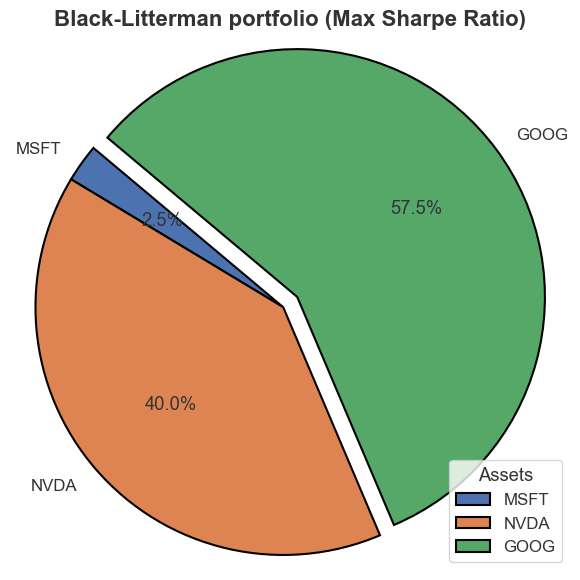

In [225]:
weights_pie_bl  = pd.Series(weights_bl)
weights_pie_bl = weights_pie_bl[weights_pie_bl > 0]

explode = [0, 0, 0.07]
plt.figure(figsize=(6, 6))
plt.pie(weights_pie_bl, 
        labels=weights_pie_bl.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5, 'linestyle': 'solid'}, 
        explode=explode)
plt.title('Black-Litterman portfolio (Max Sharpe Ratio)', fontsize=16, fontweight='bold')
plt.legend(weights_pie_bl.index, title="Assets", loc='best')
plt.tight_layout()
plt.axis('equal')
plt.show()

In [211]:
# Building Black-Litterman portfolio
black_litterman_weights = np.array([weights_bl['AAPL'], weights_bl['MSFT'], weights_bl['NVDA'],
                                   weights_bl['AMZN'], weights_bl['GOOG'], weights_bl['META'],
                                   weights_bl['TSLA']])

black_litterman_portfolio = returns_df.dot(black_litterman_weights)
black_litterman_portfolio # Black-Litterman Portfolio daily returns

Date
2014-01-02   -0.008057
2014-01-03   -0.009156
2014-01-06    0.011251
2014-01-07    0.017830
2014-01-08    0.006209
                ...   
2024-12-24    0.006444
2024-12-26   -0.002264
2024-12-27   -0.017707
2024-12-30   -0.002927
2024-12-31   -0.016223
Length: 2768, dtype: float64

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2014-01-02   2014-01-02
End Period                 2024-12-31   2024-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          3,662.98%    4,075.92%
CAGR﹪                     25.56%       26.39%

Sharpe                     1.32         1.25
Prob. Sharpe Ratio         100.0%       100.0%
Smart Sharpe               1.22         1.16
Sortino                    1.92         1.86
Smart Sortino              1.77         1.72
Sortino/√2                 1.36         1.32
Smart Sortino/√2           1.25         1.22
Omega                      1.25         1.25

Max Drawdown               -48.64%      -49.69%
Longest DD Days            570          550
Volatility (ann.)          28.05%       30.9%
R^2                        0.9          0.9
Information Ratio          0.01         0.01
Calmar            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-22,2022-11-03,2023-05-25,550,-49.693320,-48.017761
2,2018-08-30,2018-12-24,2019-12-13,471,-36.082641,-32.598499
3,2020-02-20,2020-03-16,2020-05-19,90,-32.375431,-31.454771
4,2024-07-11,2024-09-06,2024-11-06,119,-21.425761,-21.003916
5,2015-12-30,2016-02-08,2016-03-28,90,-17.371572,-17.345169


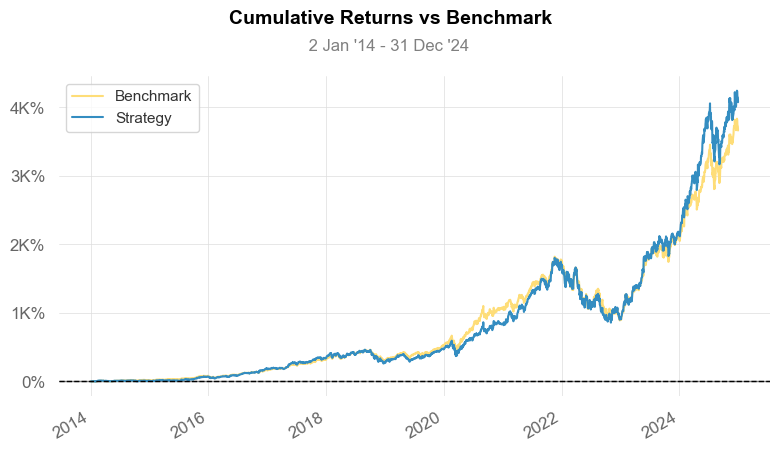

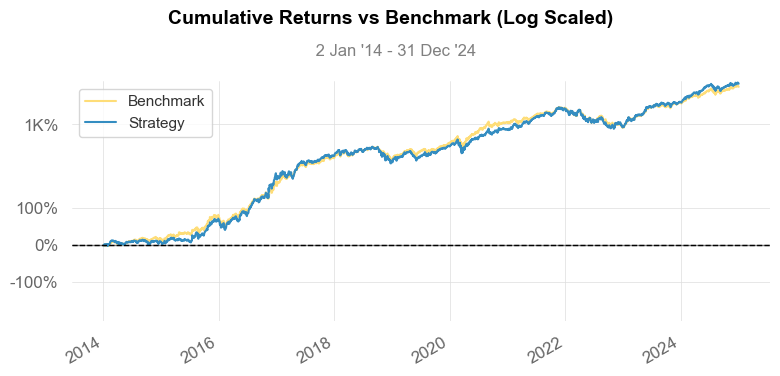

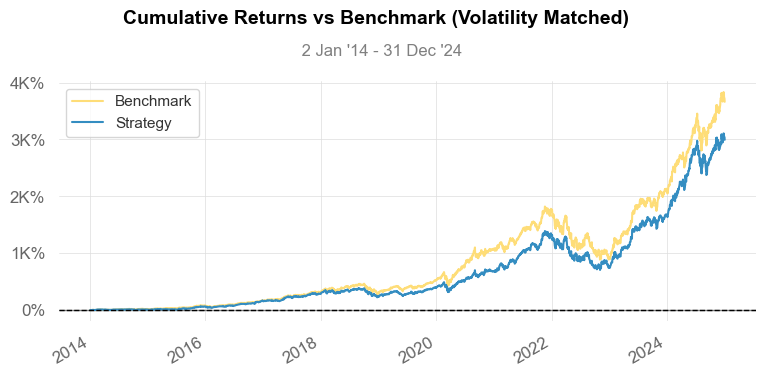

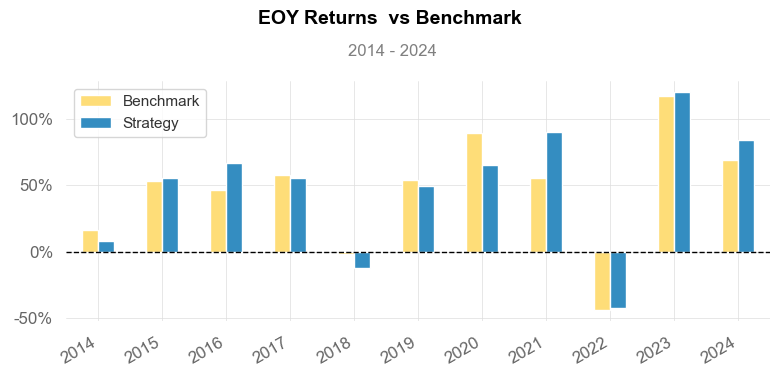

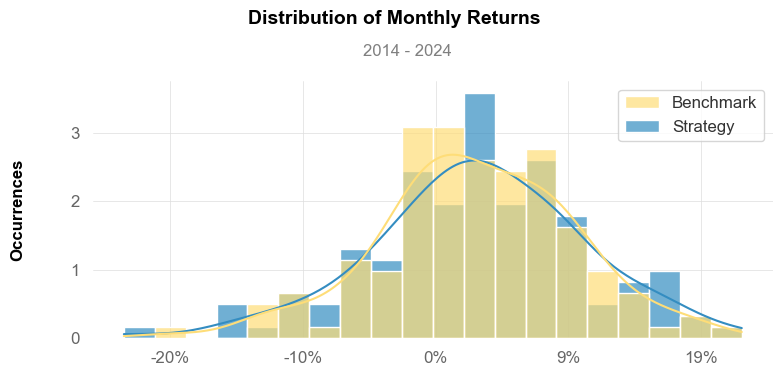

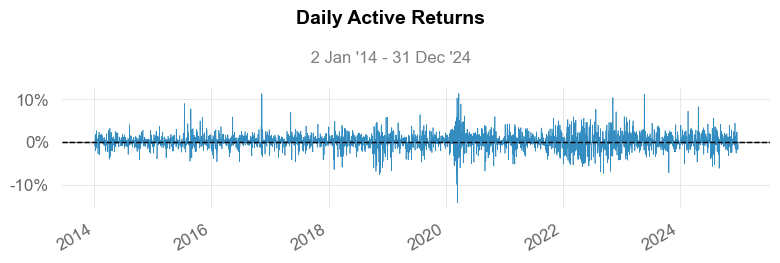

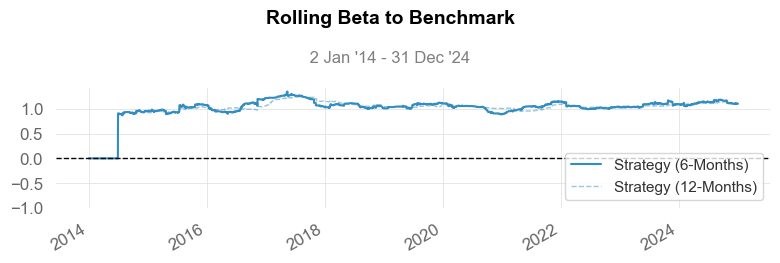

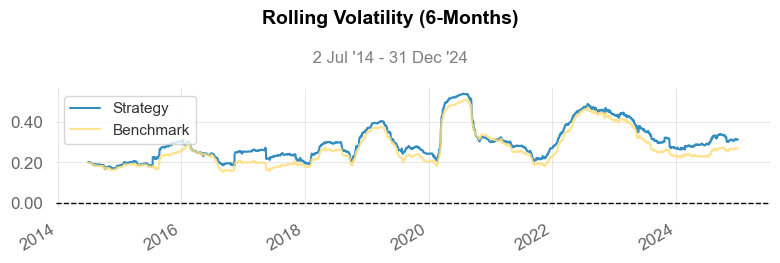

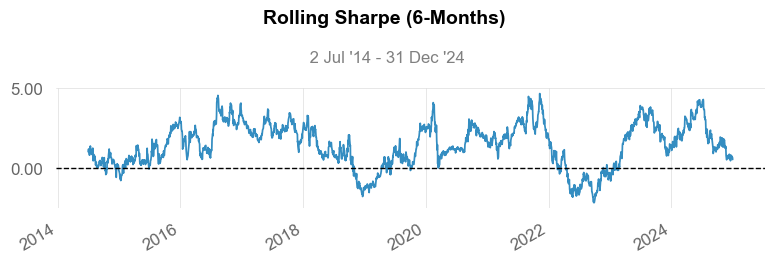

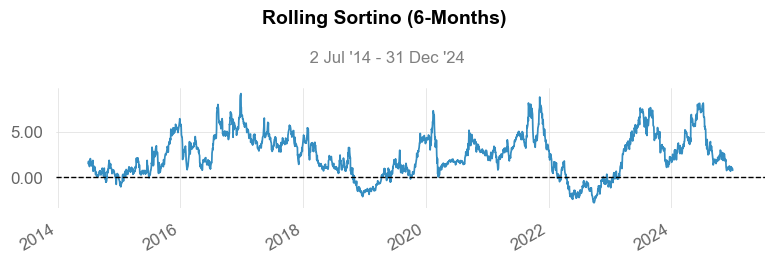

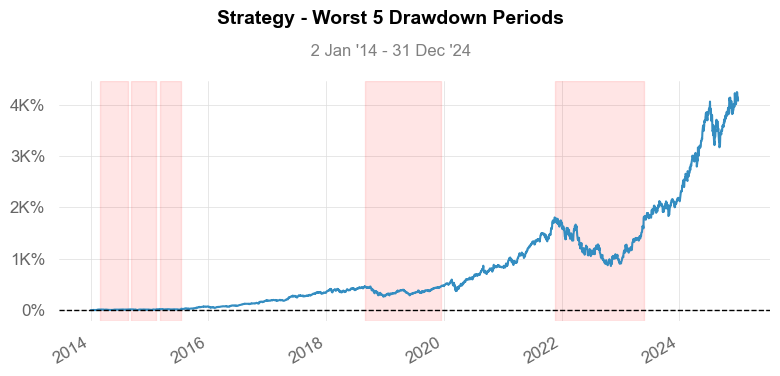

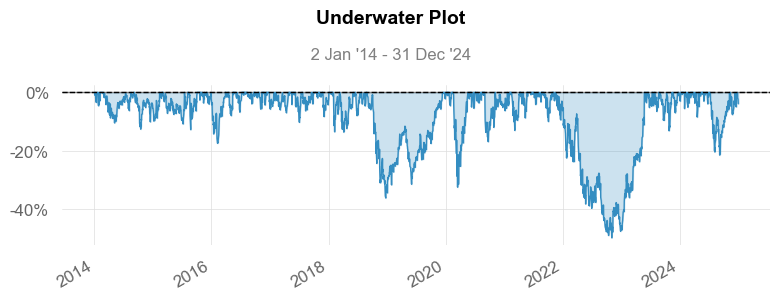

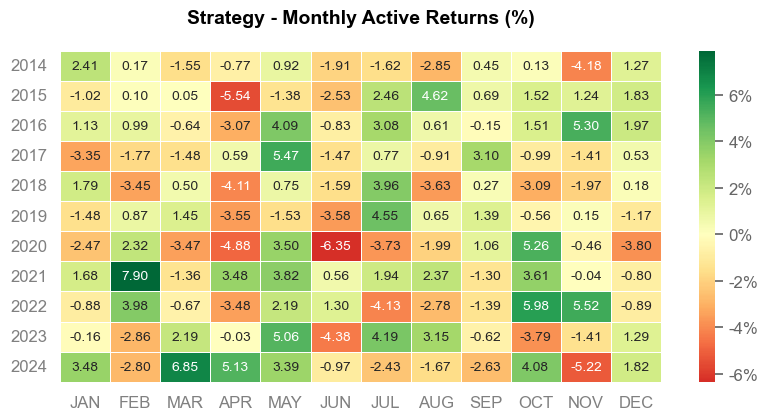

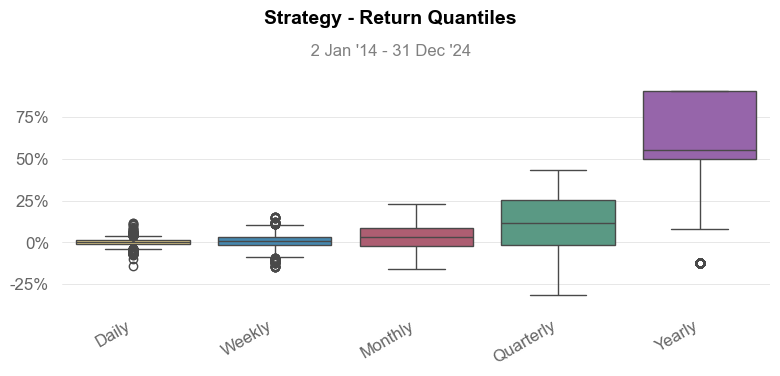

In [213]:
# Comparing Black-Litterman portfolio to the original portfolio
qs.reports.full(black_litterman_portfolio, benchmark=portfolio)